<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step1-train_vgg16_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune VGG16 CNN to Classify Gabor Tilts
### Adapted from [Tensorflow transfer learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).
--- 
### Import libraries

In [1]:
import tensorflow as tf
#from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np
tf.random.set_seed(42) #set random seed for reproducibility

Check tensorflow version

In [2]:
tf.__version__ 

'2.6.0'

### Load and prepare the data
The dataset is comprised of 18,000 total Gabors in two classes representing tilts from 45 degrees in the clockwise direction and tilts in the counterclockwise direction. The Gabors were generated in MATLAB using gen_gabor-range.m according to a range of 18 unique tilt/contrast combinations. 
- `tilts = [.1, .2, .4, .8, 1.6, 3.2]; # measured in degrees`
- `contrasts = [.3, .45, 1];  # measured in percent`  

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size is set at 32 and image size at 224 x 224 because the VGG model expects images of this size. 

We will download a zip file from OSF then extract its contents and change into the newly created directory: `content/model2_training/`

In [3]:
# @title Load data

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Model 2 Training` dataset...")
name = 'model2_training'
fname = f"{name}.zip"
url = f"https://osf.io/u2pkt/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}") #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

os.chdir(name) #move into extracted folder root
print("Download completed.")

Start downloading and unzipping `Model 2 Training` dataset...
Download completed.


In [4]:
def load_data():
    curr_dir = os.getcwd() 
    train_dir = os.path.join(curr_dir, 'train_range')
    validation_dir = os.path.join(curr_dir, 'validation_range')
    test_dir = os.path.join(curr_dir, 'test_range')
    BATCH_SIZE = 32 
    IMG_SIZE = (224, 224)
    IMG_SHAPE = IMG_SIZE + (3,) #adds a third dimension to hold 3 color channels
    train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE) 
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE) 
    class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
    return BATCH_SIZE,IMG_SIZE,IMG_SHAPE,train_dataset,validation_dataset,test_dataset,class_names

BATCH_SIZE, IMG_SIZE, IMG_SHAPE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

Found 11988 files belonging to 2 classes.
Found 4788 files belonging to 2 classes.
Found 1224 files belonging to 2 classes.


### Verify the data
To verify that the dataset looks correct, let's plot the first 9 images from the training set and display the class name above each image:

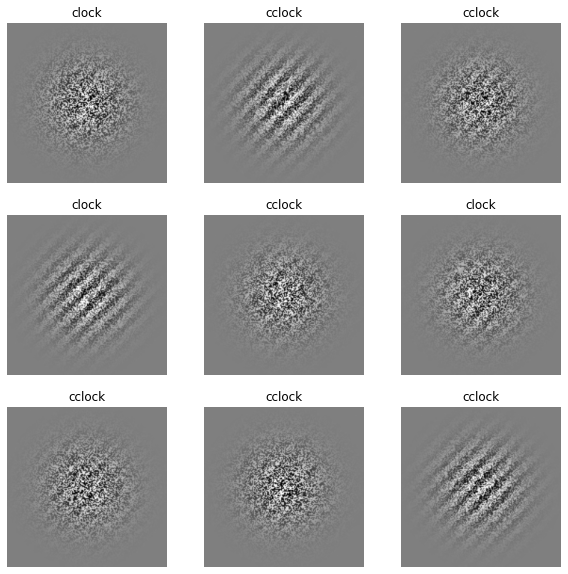

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #load first iteration batch from training dataset
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #setup axis on a 3x3 grid
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray') #plot each image
    plt.title(class_names[labels[i]]) #output associated label for chosen image
    plt.axis("off")

### Preprocess the data
Our images are RGB, but VGG16 expects images in BGR with each color channel zero-centered with respect to the ImageNet dataset, without scaling. We need to apply this transformation using the `preprocess_inputs` method.

In [6]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

### Setup buffered prefetching
We can configure the dataset for performance using buffered prefetching to load images from disk without having I/O become blocking

In [7]:
def prefetch(train_dataset, validation_dataset, test_dataset):
    AUTOTUNE = tf.data.AUTOTUNE #prompts the tf.data runtime to tune the value dynamically at runtime
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE) #will prefetch an optimal number of batches
    return train_dataset,validation_dataset,test_dataset,AUTOTUNE

train_dataset, validation_dataset, test_dataset, AUTOTUNE = prefetch(train_dataset, validation_dataset, test_dataset)

### Create the base model

Next, we create the base model VGG16 with pre-loaded weights trained on ImageNet. The top classification layer will not be loaded so we can extract features to be used in our custom Gabor classifier layer.

In [8]:
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                               include_top=False,
                                               weights='imagenet') 

58900480/58889256 [==============================] - 1s 0us/step


This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:

In [9]:
image_batch, label_batch = next(iter(train_dataset)) #image_batch= (32,224,224,3), label_batch=(32,), 32 images
feature_batch = base_model(image_batch) 
print(feature_batch.shape) 

(32, 7, 7, 512)


We extracted features from one batch of images which resulted in a reduction in total overall dimensionality of the input images from [32,224,224,3] to [32,7,7,512]

Now we can freeze the base model's layers so the weights do not change during training. Let's see what the architecture looks like.


In [10]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Define additional feature extractor layer

Next, we need to add a layer that will reduce the dimensionality further by averaging over the middle 7x7 dimensions leaving a 2d feature matrix. We will input the feature batch we created from the example batch of images earlier.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #create layer
feature_batch_average = global_average_layer(feature_batch) #avg over 7,7 
print(feature_batch_average.shape) 

(32, 512)


Now, we can input this smaller feature representation to a layer that will generate a single prediction per image using logits. A positive output means class 1 and negative class 2. We will input the feature batch average from the example batch of images to generate a vector of class predictions for each image.

In [12]:
prediction_layer = tf.keras.layers.Dense(1) #create a densely-connected NN layer with a single logit output prediction
prediction_batch = prediction_layer(feature_batch_average) #generate predictions for first batch of training images
print(prediction_batch.shape) #32 logits predicting clockwise or counterclockwise

(32, 1)


### Build the model

Finally, we can build a new model by chaining together the rescaling, base_model and feature extractors using the Keras Functional API. We will add a dropout layer just before the prediction which randomly drops 20% of the inputs to prevent overfitting during training. In practice, this means some nodes are randomly turned off.

In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE) #ensure input size is one of the predefined VGG16 requires
x = preprocess_input(inputs) 
x = base_model(x, training=False) #training=False ensures any batchNorm layer weights stay locked
x = global_average_layer(x) 
x = tf.keras.layers.Dropout(0.2)(x) 
outputs = prediction_layer(x) #define output as single prediction
model = tf.keras.Model(inputs, outputs) #build the model

Let's compile the model and check its architecture now.

In [14]:
base_learning_rate = 0.001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #use this loss since model provides a linear output
              metrics=['accuracy'])
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513   

Notice the only trainable parameters are between the global pooling 512-node layer (which has dropout applied to it) and the dense single-node prediction layer.

The 513 trainable parameters are divided between 2 `tf.variables`: weights (512) & biases (1)

In [15]:
len(model.trainable_variables) 

2

Let's see how the model performs prior to training by processing the validation set.

In [16]:
initial_epochs = 10 #define training epochs
loss0, accuracy0 = model.evaluate(validation_dataset) 
print("initial loss: {:.2f}".format(loss0)) 
print("initial accuracy: {:.2f}".format(accuracy0))

150/150 [==============================] - 56s 296ms/step - loss: 1.9214 - accuracy: 0.5000
initial loss: 1.92
initial accuracy: 0.50


As expected, the loss is quite high at 1.92 and the accuracy is chance at 0.50.

### Train the model

Now we can train the final classification layer in the model and visualize its performance when using the VGG16 base model as a fixed feature extractor.

In [17]:
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset) 

Epoch 1/10
375/375 [==============================] - 132s 349ms/step - loss: 0.8412 - accuracy: 0.5006 - val_loss: 0.6766 - val_accuracy: 0.5155
Epoch 2/10
375/375 [==============================] - 131s 348ms/step - loss: 0.7040 - accuracy: 0.5342 - val_loss: 0.6635 - val_accuracy: 0.5240
Epoch 3/10
375/375 [==============================] - 131s 349ms/step - loss: 0.6719 - accuracy: 0.5477 - val_loss: 0.6564 - val_accuracy: 0.5679
Epoch 4/10
375/375 [==============================] - 131s 349ms/step - loss: 0.6646 - accuracy: 0.5561 - val_loss: 0.6472 - val_accuracy: 0.5476
Epoch 5/10
375/375 [==============================] - 131s 349ms/step - loss: 0.6583 - accuracy: 0.5617 - val_loss: 0.6546 - val_accuracy: 0.6005
Epoch 6/10
375/375 [==============================] - 131s 349ms/step - loss: 0.6558 - accuracy: 0.5693 - val_loss: 0.6446 - val_accuracy: 0.5443
Epoch 7/10
375/375 [==============================] - 131s 349ms/step - loss: 0.6545 - accuracy: 0.5651 - val_loss: 0.6395 -

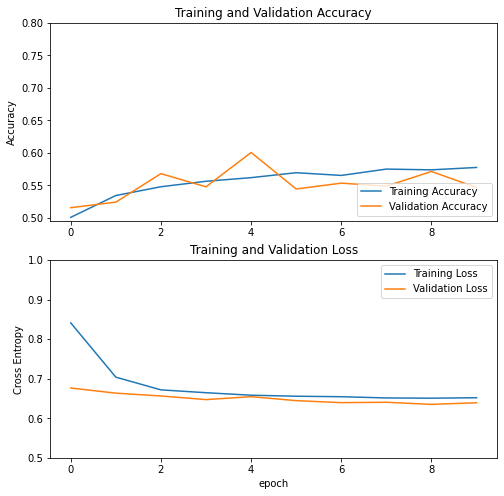

In [18]:
acc = history.history['accuracy'] #extract and store history of accuracy scores on training set as list
val_acc = history.history['val_accuracy'] #extract and store history of accuracy scores on validation set as list
loss = history.history['loss'] #extract and store history of loss scores on training set as list
val_loss = history.history['val_loss'] #extract and store history of losss scores on validation set as list
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.8])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.5,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() #accuracy trends up over time and the loss goes down

### Save the model
Before proceeding, let's save our model so far.

In [19]:
model.save('vgg16')

INFO:tensorflow:Assets written to: vgg16/assets


In [20]:
! zip -r vgg16_model.zip vgg16/

  adding: vgg16/ (stored 0%)
  adding: vgg16/keras_metadata.pb (deflated 96%)
  adding: vgg16/assets/ (stored 0%)
  adding: vgg16/saved_model.pb (deflated 90%)
  adding: vgg16/variables/ (stored 0%)
  adding: vgg16/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: vgg16/variables/variables.index (deflated 64%)


## Load the model
Next, we will load our saved model and continue to improve its accuracy by fine-tuning its last layers.

In [ ]:
# @title Download model

import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `Range model`...")
name = 'vgg16_model'
fname = f"{name}.zip"
url = f"https://osf.io/hu2jy/download" #osf share link
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content) #download file

with ZipFile(fname, 'r') as zfile:
  zfile.extractall() #extract contents

if os.path.exists(fname):
  os.remove(fname) #delete zip file
else:
  print(f"The file {fname} does not exist")

print("Download completed.")

In [ ]:
model = tf.keras.models.load_model('vgg16') 

After loading the model, the convolutional base model weights need to be frozen. 

In [21]:
model.get_layer(name='vgg16').trainable=False #get vgg16 base then freeze it
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513   

Finally, let's confirm the last layer takes in 512 features and outputs a single logit prediction.

In [22]:
print(model.get_layer(name='dense').input_shape) 
print(model.get_layer(name='dense').output_shape)

(None, 512)
(None, 1)


### Fine-tune the model
Now, we will focus on training the weights of the top layers of the convolutional base model concurrently with the classifier. The goal is to adapt specialized features found in the highest layers to work with the new dataset, rather than overwrite the generic learning found in the lowest layers. 
When fine-tuning, it is important to first make sure the classifier is trained on the new dataset, like we did above. Otherwise, if the weights are randomly initialized in the classifier, the gradient updates will be large and the pre-trained convolutional model will forget what it learned.
We will start by unfreezing the base layer and counting its layers.

In [31]:
model.get_layer(name='vgg16').trainable=True 
print("Number of layers in the base model: ", len(model.get_layer(name='vgg16').layers)) 

Number of layers in the base model:  19


In [24]:
model.get_layer(name='vgg16').layers[:18]

In [25]:
model.get_layer(name='vgg16').layers[:19]

There are 19 layers in the base model. Let's start by fine-tuning from the last couple layers of the base model onwards.

In [32]:
fine_tune_at = 17 #fine-tune from this layer onwards, non-inclusive
for layer in model.get_layer(name='vgg16').layers[:fine_tune_at]: # freeze all the layers before the `fine_tune_at` layer
  layer.trainable =  False

We have set the bottom layers (1-17, inclusive) to be untrainable. Now we recompile so the changes take effect.

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), #use lower rate since model is much larger and want to avoid overfitting
              metrics=['accuracy'])
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We now have 2,360,321 trainable parameters.

In [34]:
len(model.trainable_variables)

4

There are 4 weight and bias variables.

Finally, we can initiate training the last layers to fine-tune the network.

In [36]:
fine_tune_epochs = 10 #define additional epochs for fine_tuning
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], #start from last epoch
                         validation_data=validation_dataset)

Epoch 10/20
375/375 [==============================] - 137s 359ms/step - loss: 0.6839 - accuracy: 0.5628 - val_loss: 0.6147 - val_accuracy: 0.5825
Epoch 11/20
375/375 [==============================] - 134s 357ms/step - loss: 0.6354 - accuracy: 0.5940 - val_loss: 0.5982 - val_accuracy: 0.5975
Epoch 12/20
375/375 [==============================] - 134s 357ms/step - loss: 0.6146 - accuracy: 0.6243 - val_loss: 0.6260 - val_accuracy: 0.6410
Epoch 13/20
375/375 [==============================] - 134s 357ms/step - loss: 0.5963 - accuracy: 0.6390 - val_loss: 0.5914 - val_accuracy: 0.6706
Epoch 14/20
375/375 [==============================] - 134s 357ms/step - loss: 0.5812 - accuracy: 0.6567 - val_loss: 0.5837 - val_accuracy: 0.6222
Epoch 15/20
375/375 [==============================] - 134s 357ms/step - loss: 0.5706 - accuracy: 0.6642 - val_loss: 0.5766 - val_accuracy: 0.6280
Epoch 16/20
375/375 [==============================] - 134s 358ms/step - loss: 0.5566 - accuracy: 0.6780 - val_loss: 0

Let's visualize the performance of the fine-tuned model and check its accuracy on the test set.

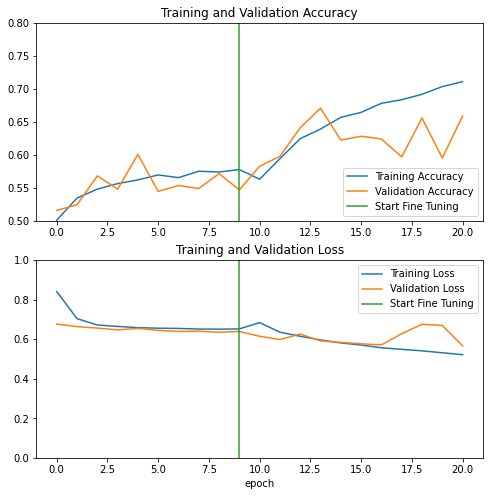

In [37]:
acc += history_fine.history['accuracy'] #extract and append fine_tune history of accuracy scores on training set as list
val_acc += history_fine.history['val_accuracy'] 
loss += history_fine.history['loss'] 
val_loss += history_fine.history['val_loss'] 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 0.8]) #zoom in on one section of plot
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

In [38]:
loss, accuracy = model.evaluate(test_dataset) 
print('Test accuracy :', accuracy)

39/39 [==============================] - 13s 328ms/step - loss: 0.5738 - accuracy: 0.6487
Test accuracy : 0.648692786693573


Overall, the fine-tuned model achieved a 64.87% accuracy on the test set. Let's save this fine-tuned version.

In [39]:
model.save('vgg16_ft')
! zip -r vgg16_ft_model.zip vgg16_ft/

INFO:tensorflow:Assets written to: vgg16_ft/assets
  adding: vgg16_ft/ (stored 0%)
  adding: vgg16_ft/keras_metadata.pb (deflated 96%)
  adding: vgg16_ft/assets/ (stored 0%)
  adding: vgg16_ft/saved_model.pb (deflated 90%)
  adding: vgg16_ft/variables/ (stored 0%)
  adding: vgg16_ft/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: vgg16_ft/variables/variables.index (deflated 65%)
